In [1]:
import numpy as np 
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/spotify_tracks_with_clusters.csv") 
df.head() 

,id,name,album,artists,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_min,year,release_date,cluster,tsne_1,tsne_2
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,['Rage Against The Machine'],False,0.470,0.978,-5.399,0.0727,0.02610,0.000011,0.3560,0.503,117.906,3.502217,1999,1999-11-02,4,66.645860,-36.375896
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,['Rage Against The Machine'],True,0.599,0.957,-5.764,0.1880,0.01290,0.000071,0.1550,0.489,103.680,3.436667,1999,1999-11-02,0,48.224667,72.048700
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,['Rage Against The Machine'],False,0.315,0.970,-5.424,0.4830,0.02340,0.000002,0.1220,0.370,149.749,4.981550,1999,1999-11-02,2,92.581080,78.466360
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,['Rage Against The Machine'],True,0.440,0.967,-5.830,0.2370,0.16300,0.000004,0.1210,0.574,96.752,3.560667,1999,1999-11-02,0,41.344658,99.569510
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,['Rage Against The Machine'],False,0.426,0.929,-6.729,0.0701,0.00162,0.105000,0.0789,0.539,127.059,3.426667,1999,1999-11-02,4,77.623955,-31.373718


In [3]:
# Simulating promoted label (as proxy for campaign modeling) 
#df['promoted'] = ((df['valence'] > 0.7) & (df['energy'] > 0.7)).astype(int) 

# Create a synthetic but less deterministic label
df['promoted'] = (
    ((df['valence'] > 0.6) & (df['energy'] > 0.6)) |
    (df['danceability'] > 0.75)
).astype(int)

# Add random noise
flip_mask = np.random.rand(len(df)) < 0.05  # 5% label flipping
df.loc[flip_mask, 'promoted'] = 1 - df.loc[flip_mask, 'promoted']

In [4]:
df['promoted'].value_counts() 

promoted
0    885685
1    315540
Name: count, dtype: int64

In [5]:
# Preparing features for classification 
features = [
    'danceability', 
    'energy', 
    'loudness', 
    'speechiness', 
    'acousticness', 
    'instrumentalness', 
    'liveness', 
    'valence', 
    'tempo', 
    'duration_min', 
    'year'
] 

X = df[features] 
y = df['promoted'] 

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42) 

In [6]:
# Train XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/home/flynn/projects/spotify-query-lab/.env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:24:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [7]:
# Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [8]:
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97    265706
           1       0.95      0.85      0.90     94662

    accuracy                           0.95    360368
   macro avg       0.95      0.92      0.93    360368
weighted avg       0.95      0.95      0.95    360368

AUC: 0.9187530758457005


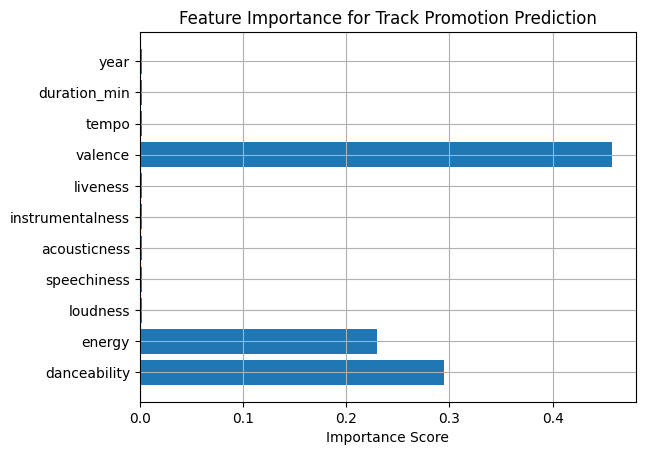

In [9]:
# Feature importance
importances = model.feature_importances_
plt.barh(features, importances)
plt.title("Feature Importance for Track Promotion Prediction")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()

In [10]:
df.to_csv("../data/spotify_tracks_with_clusters_and_uplift.csv", index=False)

In [11]:
# Save the model 
import pickle 
import os 

os.makedirs("../models", exist_ok=True) 

with open("../models/xgb_promotion_model.pkl", "wb") as f: 
    pickle.dump(model, f)